# Predicting Credit Default on Credit Card Dataset

---

In [1]:
import pandas as pd

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls'
df = pd.read_excel(url,skiprows=1)

# Rename 
df.rename(columns={'PAY_0':'PAY_1',
                  'default payment next month': 'payment_default'},
         inplace=True)

# drop ID
df.drop(['ID'],axis=1,inplace=True)

# print columns
print(df.columns)

# print shape
print(df.shape)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'payment_default'],
      dtype='object')
(30000, 24)


## Feature Engineering
Create additional features and add them to `df` by squaring the following variables  
- LIMIT_BAL  
- All BILL_AMT variables  
- All PAY_AMT variables  

In [2]:
# limit bal
df['LIMIT_BAL_2'] = df['LIMIT_BAL'] ** 2

# bill amt
bill_amts = [col for col in df.columns if 'BILL_AMT' in col]
bill_2 = df[bill_amts] ** 2
bill_2 = bill_2.add_suffix('_2')

# pay amt
pay_amts = [col for col in df.columns if 'PAY_AMT' in col]
pay_2 = df[pay_amts] ** 2
pay_2 = pay_2.add_suffix('_2')

# merge into df 
df = pd.concat([df, bill_2, pay_2],axis=1)

### Cleaning data and dealing with categorical features

Gender variables


In [3]:
print(df.SEX.value_counts(),'\n')

sex = pd.get_dummies(df.SEX).rename(columns={1:'SEX_MALE', 2:'SEX_FEMALE'})
df.drop('SEX',axis=1, inplace=True)
df = pd.concat([df,sex],axis=1)

2    18112
1    11888
Name: SEX, dtype: int64 



In `pd.get_dummies`, two new columns were created by way of one-hot encoding. One for `1` (male) from the `SEX` column, another for `2` (female). This was stored into a new dataframe called `sex`. The column names were also renamed into `'SEX_MALE'` and `'SEX_FEMALE'`. Afterwhich, the original `SEX` column was removed. Lastly, the original dataframe and the sex dataframe were merged.

Look into `MARRIAGE` variable

In [4]:
print(df.MARRIAGE.value_counts())

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64


In [5]:
print(df.MARRIAGE.value_counts(normalize=True).round(4)*100)

2    53.21
1    45.53
3     1.08
0     0.18
Name: MARRIAGE, dtype: float64


Based from the UCI Website, these are what the numbers represent:
1 = married; 2 = single; 3 = others

Most of the data mostly consist of either married or single people. 1% are categorized as others, while a negligible percentage are listed as 0.

There are, however, no information for what `0` represents. This may mean they did not fill out their marriage status. Most of them are female.

In [6]:
df = df[df.MARRIAGE!=0]
marriage = pd.get_dummies(df.MARRIAGE).rename(columns={1:'MARRIAGE_MARRIED',
                                                       2:'MARRIAGE_SINGLE',
                                                       3:'MARRIAGE_OTHER'})
df = pd.concat([df.drop('MARRIAGE',axis=1),marriage], axis=1)

I removed the ones listed as 0 for the following reasons:
- Imputing might distort the information
- It can be hard to predict whether someone is married or single
- There are only a handful of entries listed as `0`

However, in other cases, it can also be useful to try and predict the `MARRIAGE` column. Non-zeros as training data, zeros as the data to be predicted. For this task, I have opted to remove them for simplicity.

After cleaning up the `MARRIAGE` column, the process is the same with Q1. The orginal `MARRIAGE` column is dropped, I then used `.get_dummies` on the `MARRIAGE` column to one-hot encode them, then renamed the columns, and put them together with the whole dataframe.


Convert values {0, 4, 5, 6} into the value 4 in the column `EDUCATION`

In [7]:
df.EDUCATION.replace([0, 4, 5, 6], 4 , inplace=True)

---

#### Preparing X and y arrays

Create `y` from 12,500 consecutive observations starting from observation 1,000, i.e. observation 1,000 is the starting point, of 'payment_default' column from df. Similarly, create `X`  using 12,500 corresponding observatations of all the remaining features in `df` (2.5 marks)

In [8]:
y = df.payment_default[1000:13500]
X = df[1000:13500].drop('payment_default',axis=1)

#### 70-30 split

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y, test_size=.3)

---

### Hyperparameter tuning pipeline
- PCA
- SVC

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),PCA(random_state=1),SVC(random_state=1))

In pipelines, parameters has to be accessed differently as seen below:

In [11]:
from sklearn.model_selection import GridSearchCV

param_range = [0.1, 1, 10]

params = [{'svc__C': param_range,
           'svc__kernel': ['linear','sigmoid','rbf'],
           'pca__n_components':[1,4,9]}]
          
gs = GridSearchCV(pipe_svc, params, scoring='accuracy', refit=True,
                    cv=10, n_jobs=-1)
          
gs.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(random_state=1)),
                                       ('svc', SVC(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'pca__n_components': [1, 4, 9],
                          'svc__C': [0.1, 1, 10],
                          'svc__kernel': ['linear', 'sigmoid', 'rbf']}],
             scoring='accuracy')

Get best parameters


In [12]:
best_classifier = gs.best_estimator_
print('Cross validation:',gs.best_score_.round(3))
print(f'Train accuracy: {best_classifier.score(X_train, y_train):.3f}')
print(f'Test accuracy: {best_classifier.score(X_test, y_test):.3f}')

Cross validation: 0.795
Train accuracy: 0.799
Test accuracy: 0.789


<hr style="width:35%;margin-left:0;"> 

#### Confusion Matrix  

In [13]:
from sklearn.metrics import confusion_matrix

y_pred = best_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[2802   99]
 [ 692  157]]


Checking the True Positive Rate, False Positive Rate and Precision

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


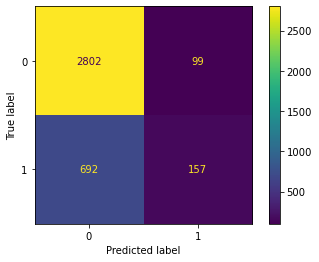

In [14]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plot_cm = plot_confusion_matrix(best_classifier, X_test, y_test)
plt.show()

In [15]:
print('True Positive Rate:')
(157/(157+692))

True Positive Rate:


0.18492343934040048

In [16]:
print('False Positive Rate:')
(99/(99+2802))

False Positive Rate:


0.03412616339193381

In [17]:
print('Precision:')
(157/(157+99))

Precision:


0.61328125

# Observations and comments

In [18]:
df.payment_default.value_counts()

0    23315
1     6631
Name: payment_default, dtype: int64

The model's true positive rate is low, which means that in most cases, the model might predict that a person will not default but will actually default. This is a great risk for the company, as a signficant exposure might force the company to go bankrupt. If there are too much people that the company lends money to but defaults, then the company will lose a lot of money.

One remedy for the model might be to add more samples where a person defaults. Currently, ~77% of the data (23,315) are labelled as did not default on payment, while only ~23% (6,631) are labelled as defaulted on payment. Ideally, the mix should be almost 50-50. In this case, it would be ideal to add ~17,000 more data that are labelled as defaulted on payments.

On the other hand, I have tried to reduce the data to have equal splits of default and non-default (see code below). This has resulted in a much better true positive rate (TPR) or recall despite a lower accuracy. In this case, it improved from a recall rate of 18.5% to 53.8% just by dropping some data to make the model have equal parts of default and non-defaults.

In conclusion, accuracy may not always be the best metric to optimise. In cases like the credit card default data, recall score will be more important for the business as a low recall score means the model is prone to not being able to predict that a person will default, and this will have signficant impact on the business.

##### Make new df where split of y labels are equal

In [19]:
df0 = df[df['payment_default']==0].sample(6631)
df1 = df[df['payment_default']==1]
new_df = pd.concat([df0,df1])

y = new_df.payment_default
X = new_df.drop('payment_default',axis=1)

##### Data split, grid search

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, stratify=y, test_size=.3)


gs2 = GridSearchCV(pipe_svc, params, scoring='accuracy', refit=True,
                    cv=10, n_jobs=-1)
          
gs2.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('pca', PCA(random_state=1)),
                                       ('svc', SVC(random_state=1))]),
             n_jobs=-1,
             param_grid=[{'pca__n_components': [1, 4, 9],
                          'svc__C': [0.1, 1, 10],
                          'svc__kernel': ['linear', 'sigmoid', 'rbf']}],
             scoring='accuracy')

##### Confusion matrix and score calculations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


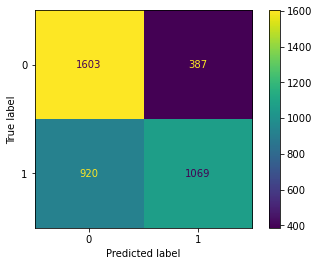

In [21]:
best_clf_2 = gs2.best_estimator_
plot_confusion_matrix(best_clf_2, X_test, y_test)

In [23]:
from sklearn.metrics import recall_score
print('True Positive Rate (Recall):')
recall_score(y_test,best_clf_2.predict(X_test)).round(4)

True Positive Rate (Recall):


0.5375

In [24]:
print('False Positive Rate:')
(482/(482+1508))

False Positive Rate:


0.2422110552763819

In [25]:
print('Precision:')
(1131/(1131+482))

Precision:


0.7011779293242405

In [26]:
print('Accuracy score:\n', best_clf_2.score(X_test, y_test).round(4))

Accuracy score:
 0.6715
